In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from torchvision import models
import torch.utils.data
from efficientnet_pytorch import EfficientNet

# First step: Data Preprocessing
 Splitting the dataset

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224 to ensure compatibility with the input dimensions of the CNN models.
    transforms.RandomHorizontalFlip(), # Apply horizontal flipping
    transforms.ToTensor(), # Convert to tensor to feed into the model because PyTorch models expect tensors as input.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizing the image data for better convergence during training.
])

# Loading the full dataset
dataset = ImageFolder("/Users/matheusabdao/iCloud Drive (Archive)/Documents/Salar_winter_2024/Project_Image_Recognition/animal_10/raw-img", transform=transform)

# Splitting into train and validation sets (80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Showing classes names
print(f"Classes: {dataset.classes}")

# Showing the split
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device('mps') # Check if GPU is available on mac(i used a mac,cuda is not available,CUDA is exclusive to NVIDIA GPUs, MPS is optimized for Apple)
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print(f"Using device: {device}")

Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Training samples: 20943, Validation samples: 5236
Using device: mps


# Using ShuffleNet
ShuffleNet is designed for mobile devices and is very efficient in terms of computation and memory usage

In [ ]:
# Loading the pretrained MobileNet model
shufflenet = models.shufflenet_v2_x0_5(weights='DEFAULT')

# Freezing all layers in the model
for param in shufflenet.parameters(): 
    param.requires_grad = False 
    
# Replace the last fully connected layer with a new one to match the number of classes ( 10 on this case)
num_features = shufflenet.fc.in_features
shufflenet.fc = nn.Linear(num_features, 10)  # 10 classes (cat, dog, ...)

In [ ]:
optimizer_shufflenet = optim.Adam(shufflenet.parameters(), lr=0.001)

# Move the model to the appropriate device
shufflenet.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

# Using EfficientNet Lite
EfficientNet Lite models are optimized versions of EfficientNet that are designed to be lightweight and fast while maintaining good accuracy. They are suitable for mobile and edge devices

In [ ]:
# Load the pretrained EfficientNet Lite model
efficientnet = EfficientNet.from_pretrained('efficientnet-b0') # i chose b0 because it is the smallest one and it is faster

for param in efficientnet.parameters():
    param.requires_grad = False
    
num_features = efficientnet._fc.in_features
efficientnet._fc = nn.Linear(num_features, 10)  

Loaded pretrained weights for efficientnet-b0


In [6]:
optimizer_efficientnet = optim.Adam(efficientnet.parameters(), lr=0.001)

# Move the model to the appropriate device
efficientnet.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

# Training function for the model

In [ ]:
criterion = nn.CrossEntropyLoss()
epochs = 10 
def train_model(model, optimizer, criterion, epochs):
    model.to(device)
    for epoch in range(epochs):
        correct = 0
        total = 0
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)

            # Forward pass 
            outputs = model(images) 

            # Calculate loss
            loss = criterion(outputs, labels)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Backward pass and optimization
            loss.backward() # here we will calculate the gradients of the loss
            optimizer.step()

            # Print loss every 100 batches and calculate accuracy
            if (i + 1) % 100 == 0:
                _, preds = torch.max(outputs, 1) 
                correct += (preds == labels).sum().item() 
                total += labels.size(0) 
                accuracy = correct / total * 100 
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")


# Evaluation function

In [ ]:
def evaluate_model(model): 
    model.eval()
    with torch.no_grad():
        correct = 0 
        total = 0 
        for data in val_loader: 
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print(f'Test Accuracy of the model on the {total} test images: {(correct / total) * 100:.2f}%')

# Training ShuffleNet and evaluate

In [9]:
optimizer_shufflenet = optim.Adam(shufflenet.fc.parameters(), lr=0.001)

print("Training ShuffleNet...")
train_model(shufflenet, optimizer_shufflenet, criterion, epochs)

Training ShuffleNet...
Epoch 1/10, Loss: 1.9451, Accuracy: 37.50%
Epoch 1/10, Loss: 1.7897, Accuracy: 43.75%
Epoch 1/10, Loss: 1.5820, Accuracy: 45.83%
Epoch 1/10, Loss: 1.4897, Accuracy: 50.00%
Epoch 1/10, Loss: 1.2571, Accuracy: 54.37%
Epoch 1/10, Loss: 1.3625, Accuracy: 55.73%
Epoch 2/10, Loss: 1.2703, Accuracy: 56.25%
Epoch 2/10, Loss: 0.9928, Accuracy: 68.75%
Epoch 2/10, Loss: 1.0422, Accuracy: 71.88%
Epoch 2/10, Loss: 0.8413, Accuracy: 75.78%
Epoch 2/10, Loss: 0.8563, Accuracy: 76.25%
Epoch 2/10, Loss: 0.9748, Accuracy: 76.04%
Epoch 3/10, Loss: 0.6809, Accuracy: 90.62%
Epoch 3/10, Loss: 0.7607, Accuracy: 87.50%
Epoch 3/10, Loss: 0.7207, Accuracy: 85.42%
Epoch 3/10, Loss: 0.7619, Accuracy: 83.59%
Epoch 3/10, Loss: 0.5599, Accuracy: 85.62%
Epoch 3/10, Loss: 0.6622, Accuracy: 85.42%
Epoch 4/10, Loss: 0.7773, Accuracy: 75.00%
Epoch 4/10, Loss: 0.6059, Accuracy: 81.25%
Epoch 4/10, Loss: 0.5079, Accuracy: 84.38%
Epoch 4/10, Loss: 0.6538, Accuracy: 84.38%
Epoch 4/10, Loss: 0.6476, Accur

In [10]:
print("Evaluating ShuffleNet...")
evaluate_model(shufflenet)

Evaluating ShuffleNet...
Test Accuracy of the model on the 5236 test images: 87.70%


# Training EfficientNet Lite and evaluate

In [11]:
optimizer_efficientnet = optim.Adam(efficientnet.parameters(), lr=0.001)

print("Training EfficientNet Lite...")
train_model(efficientnet, optimizer_efficientnet, criterion, epochs)

Training EfficientNet Lite...
Epoch 1/10, Loss: 0.6009, Accuracy: 84.38%
Epoch 1/10, Loss: 0.2129, Accuracy: 92.19%
Epoch 1/10, Loss: 0.3674, Accuracy: 90.62%
Epoch 1/10, Loss: 0.3455, Accuracy: 91.41%
Epoch 1/10, Loss: 0.2679, Accuracy: 92.50%
Epoch 1/10, Loss: 0.2277, Accuracy: 92.71%
Epoch 2/10, Loss: 0.2641, Accuracy: 93.75%
Epoch 2/10, Loss: 0.5988, Accuracy: 84.38%
Epoch 2/10, Loss: 0.0929, Accuracy: 88.54%
Epoch 2/10, Loss: 0.2437, Accuracy: 89.84%
Epoch 2/10, Loss: 0.3340, Accuracy: 88.75%
Epoch 2/10, Loss: 0.4861, Accuracy: 88.02%
Epoch 3/10, Loss: 0.0460, Accuracy: 100.00%
Epoch 3/10, Loss: 0.3814, Accuracy: 96.88%
Epoch 3/10, Loss: 0.1969, Accuracy: 94.79%
Epoch 3/10, Loss: 0.2450, Accuracy: 94.53%
Epoch 3/10, Loss: 0.2656, Accuracy: 94.38%
Epoch 3/10, Loss: 0.1219, Accuracy: 94.27%
Epoch 4/10, Loss: 0.1325, Accuracy: 96.88%
Epoch 4/10, Loss: 0.3681, Accuracy: 90.62%
Epoch 4/10, Loss: 0.0278, Accuracy: 93.75%
Epoch 4/10, Loss: 0.1412, Accuracy: 94.53%
Epoch 4/10, Loss: 0.252

In [12]:
print("Evaluating EfficientNet Lite...")
evaluate_model(shufflenet)

Evaluating EfficientNet Lite...
Test Accuracy of the model on the 5236 test images: 87.61%


## Transfer Learning

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

# Train MobileNetV2 and evaluate


In [ ]:
mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V2')

for param in mobilenet.parameters():
    param.requires_grad = False

# Modify the classifier to have 10 output classes
num_ftrs = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(num_ftrs, 10) 
optimizer_mobilenet = optim.Adam(mobilenet.parameters(), lr=0.001)

In [15]:
print("Training MobileNetV2...")
train_model(mobilenet, optimizer_mobilenet, criterion, epochs)

Training MobileNetV2...
Epoch 1/10, Loss: 0.5909, Accuracy: 87.50%
Epoch 1/10, Loss: 0.2988, Accuracy: 89.06%
Epoch 1/10, Loss: 0.1276, Accuracy: 92.71%
Epoch 1/10, Loss: 0.1692, Accuracy: 92.97%
Epoch 1/10, Loss: 0.2582, Accuracy: 93.12%
Epoch 1/10, Loss: 0.0704, Accuracy: 94.27%
Epoch 2/10, Loss: 0.2714, Accuracy: 90.62%
Epoch 2/10, Loss: 0.1348, Accuracy: 92.19%
Epoch 2/10, Loss: 0.1792, Accuracy: 93.75%
Epoch 2/10, Loss: 0.1714, Accuracy: 94.53%
Epoch 2/10, Loss: 0.1756, Accuracy: 95.00%
Epoch 2/10, Loss: 0.1799, Accuracy: 94.27%
Epoch 3/10, Loss: 0.1927, Accuracy: 93.75%
Epoch 3/10, Loss: 0.0607, Accuracy: 95.31%
Epoch 3/10, Loss: 0.1109, Accuracy: 95.83%
Epoch 3/10, Loss: 0.1723, Accuracy: 95.31%
Epoch 3/10, Loss: 0.2340, Accuracy: 95.00%
Epoch 3/10, Loss: 0.2617, Accuracy: 93.75%
Epoch 4/10, Loss: 0.1875, Accuracy: 93.75%
Epoch 4/10, Loss: 0.0964, Accuracy: 96.88%
Epoch 4/10, Loss: 0.0848, Accuracy: 96.88%
Epoch 4/10, Loss: 0.3161, Accuracy: 94.53%
Epoch 4/10, Loss: 0.0320, Accu

In [16]:
print("Evaluating MobileNetV2...")
evaluate_model(mobilenet)

Evaluating MobileNetV2...
Test Accuracy of the model on the 5236 test images: 95.63%


# Train SqueezeNet and evaluate

In [ ]:
squeezenet = models.squeezenet1_0(weights='DEFAULT')

for param in squeezenet.parameters():
    param.requires_grad = False

# Modify the classifier to have 10 output classes
num_ftrs = squeezenet.classifier[1].in_channels
squeezenet.classifier[1] = nn.Conv2d(num_ftrs, 10, kernel_size=(1, 1), stride=(1, 1))
squeezenet.num_classes = 10
optimizer_squeezenet = optim.Adam(squeezenet.parameters(), lr=0.001)

In [18]:
print("Training SqueezeNet...")
train_model(squeezenet, optimizer_squeezenet, criterion, epochs)

Training SqueezeNet...
Epoch 1/10, Loss: 0.4137, Accuracy: 87.50%
Epoch 1/10, Loss: 0.5707, Accuracy: 82.81%
Epoch 1/10, Loss: 0.3900, Accuracy: 86.46%
Epoch 1/10, Loss: 0.5672, Accuracy: 86.72%
Epoch 1/10, Loss: 0.3127, Accuracy: 88.12%
Epoch 1/10, Loss: 0.4609, Accuracy: 88.54%
Epoch 2/10, Loss: 0.2410, Accuracy: 93.75%
Epoch 2/10, Loss: 0.2719, Accuracy: 92.19%
Epoch 2/10, Loss: 0.3316, Accuracy: 90.62%
Epoch 2/10, Loss: 0.3336, Accuracy: 91.41%
Epoch 2/10, Loss: 0.2390, Accuracy: 91.25%
Epoch 2/10, Loss: 0.2292, Accuracy: 91.15%
Epoch 3/10, Loss: 0.1206, Accuracy: 93.75%
Epoch 3/10, Loss: 0.0400, Accuracy: 96.88%
Epoch 3/10, Loss: 0.1122, Accuracy: 96.88%
Epoch 3/10, Loss: 0.0302, Accuracy: 97.66%
Epoch 3/10, Loss: 0.3569, Accuracy: 96.25%
Epoch 3/10, Loss: 0.1740, Accuracy: 95.31%
Epoch 4/10, Loss: 0.3175, Accuracy: 90.62%
Epoch 4/10, Loss: 0.0815, Accuracy: 93.75%
Epoch 4/10, Loss: 0.2453, Accuracy: 93.75%
Epoch 4/10, Loss: 0.2236, Accuracy: 93.75%
Epoch 4/10, Loss: 0.1961, Accur

In [19]:
print("Evaluating SqueezeNet...")
evaluate_model(squeezenet)

Evaluating SqueezeNet...
Test Accuracy of the model on the 5236 test images: 92.49%


## **Evaluating the performance of the four models (ShuffleNet, EfficientNet, MobileNetV2, and SqueezeNet)**

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define Evaluation Metrics Function

In [ ]:
def evaluate_model_metrics(model):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calculating metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    # Printting the results
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    return all_labels, all_preds

# Evaluate All Models

In [ ]:
print("Evaluating ShuffleNet...")
labels_shufflenet, preds_shufflenet = evaluate_model_metrics(shufflenet) 

print("\nEvaluating EfficientNet...")
labels_efficientnet, preds_efficientnet = evaluate_model_metrics(efficientnet)

print("\nEvaluating MobileNetV2...")
labels_mobilenet, preds_mobilenet = evaluate_model_metrics(mobilenet)

print("\nEvaluating SqueezeNet...")
labels_squeezenet, preds_squeezenet = evaluate_model_metrics(squeezenet)

Evaluating ShuffleNet...
Accuracy: 0.8759
Precision: 0.8756
Recall: 0.8759
F1 Score: 0.8750

Evaluating EfficientNet...
Accuracy: 0.9631
Precision: 0.9633
Recall: 0.9631
F1 Score: 0.9631

Evaluating MobileNetV2...
Accuracy: 0.9563
Precision: 0.9567
Recall: 0.9563
F1 Score: 0.9562

Evaluating SqueezeNet...
Accuracy: 0.9244
Precision: 0.9259
Recall: 0.9244
F1 Score: 0.9241


# Plot Confusion Matrix

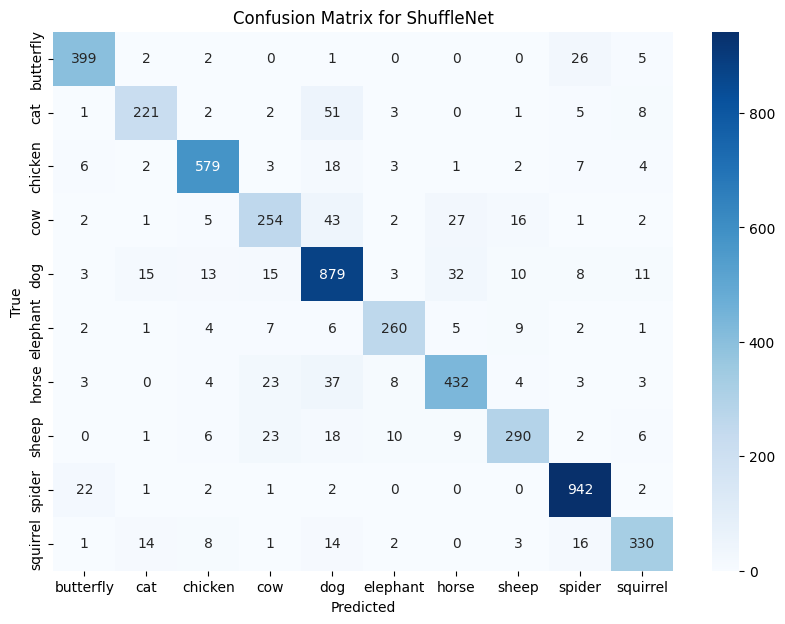

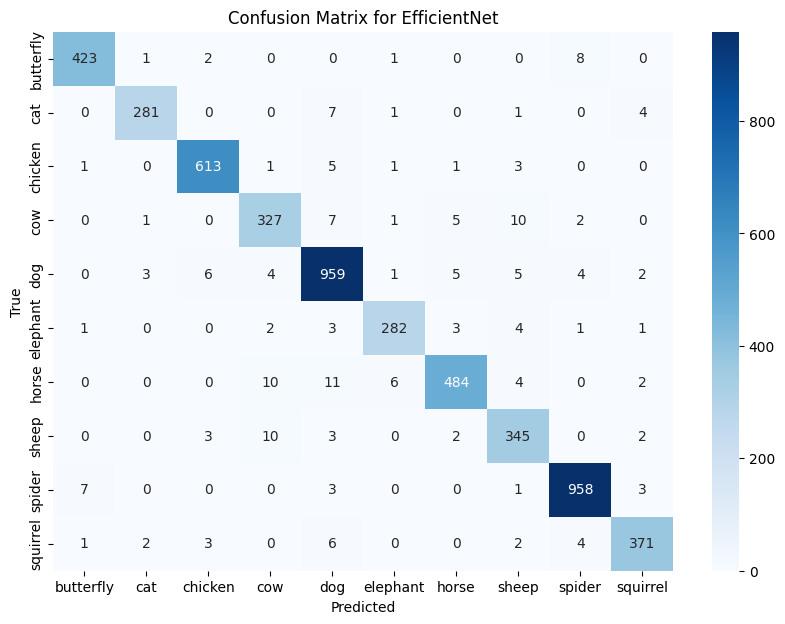

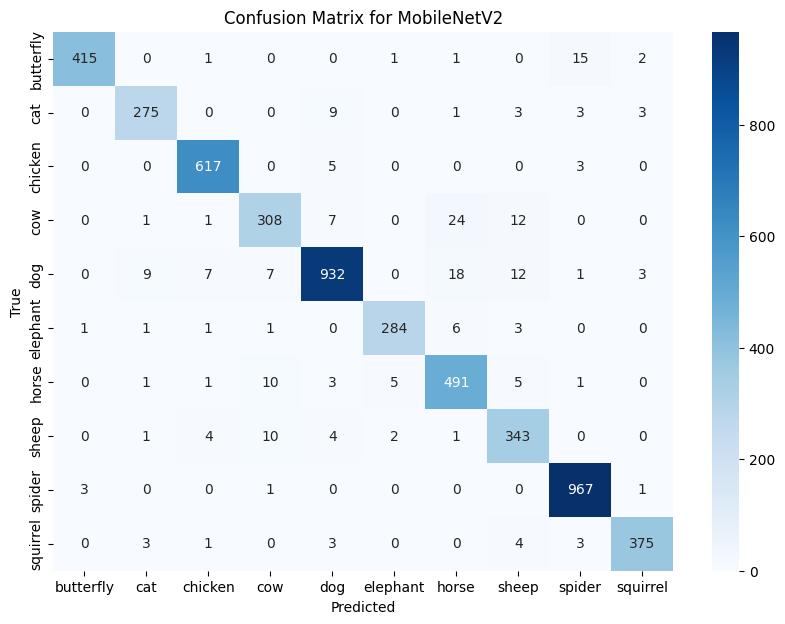

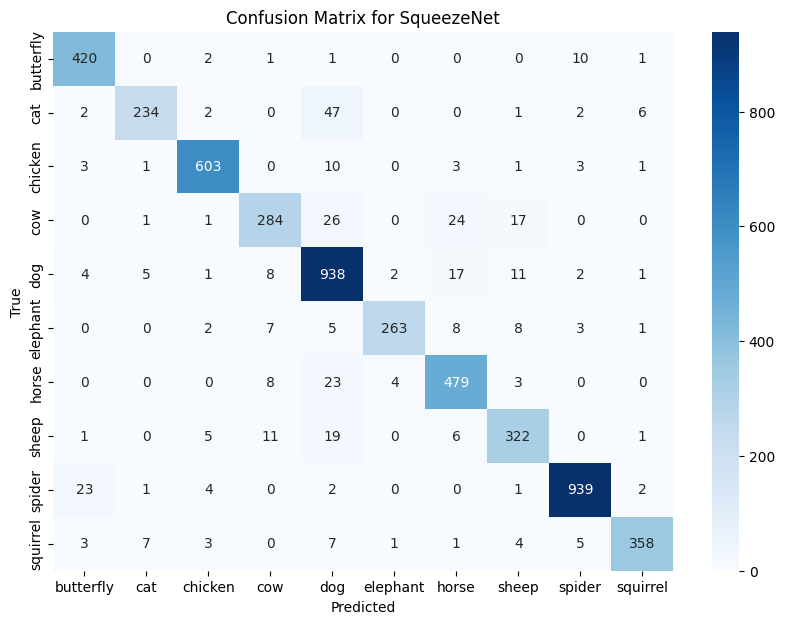

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plottin confusion matrices for all models
plot_confusion_matrix(labels_shufflenet, preds_shufflenet, "ShuffleNet")
plot_confusion_matrix(labels_efficientnet, preds_efficientnet, "EfficientNet")
plot_confusion_matrix(labels_mobilenet, preds_mobilenet, "MobileNetV2")
plot_confusion_matrix(labels_squeezenet, preds_squeezenet, "SqueezeNet")

# Plot Precision-Recall Curves

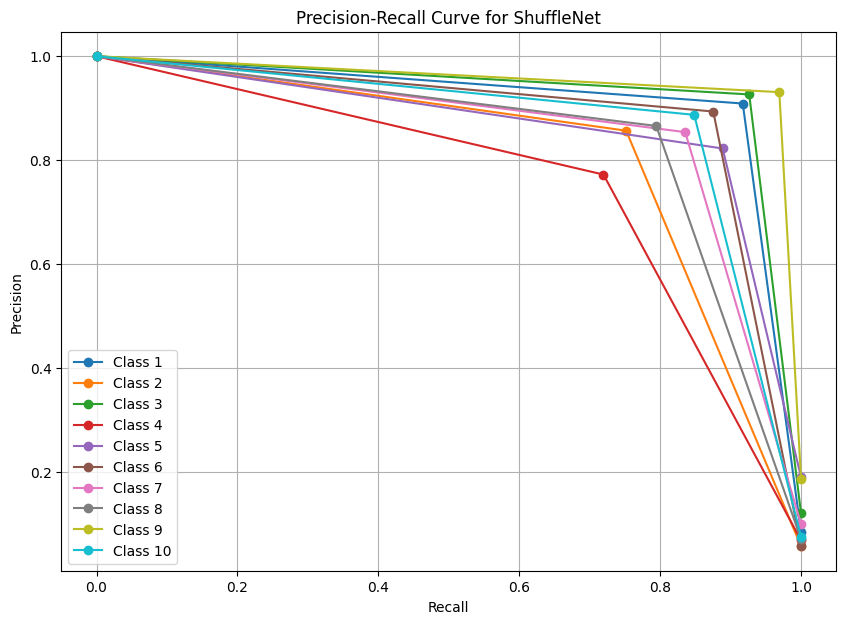

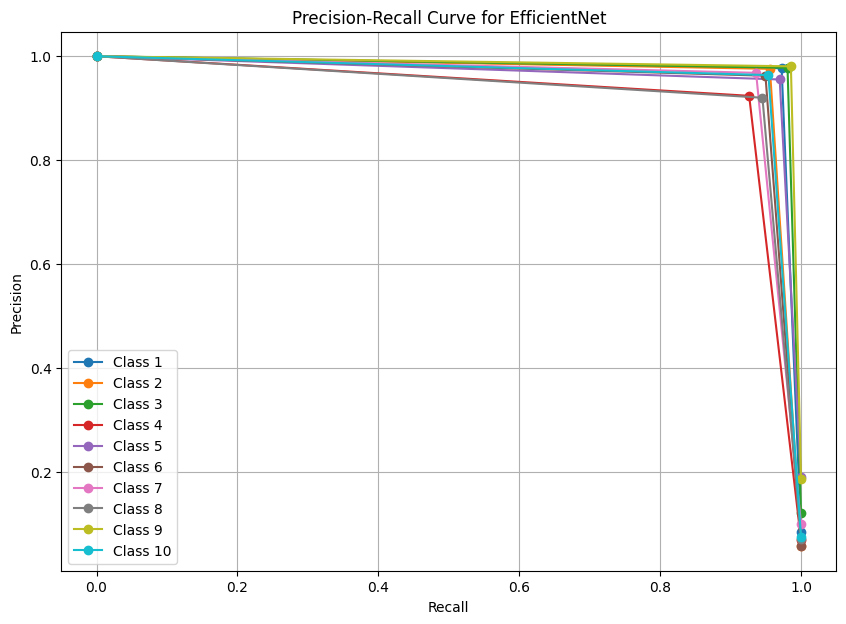

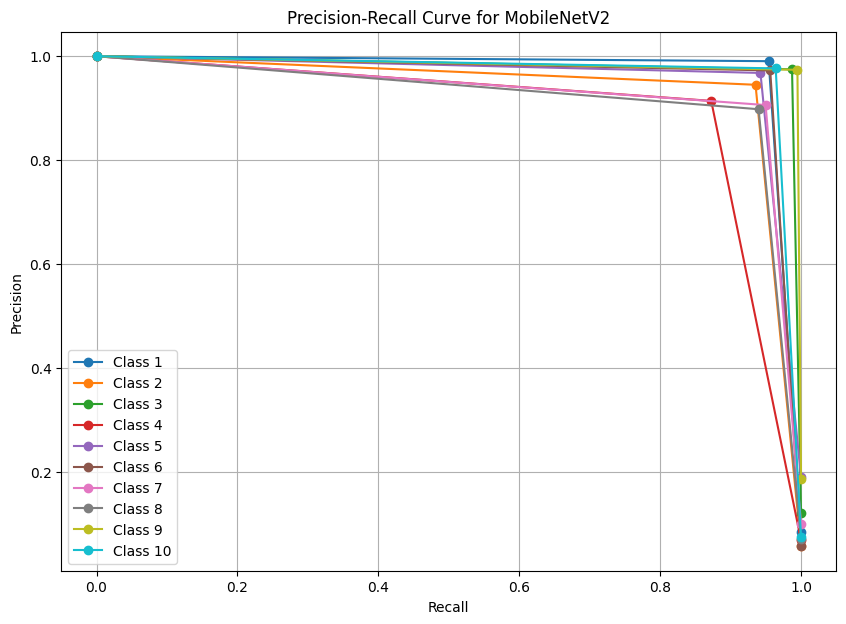

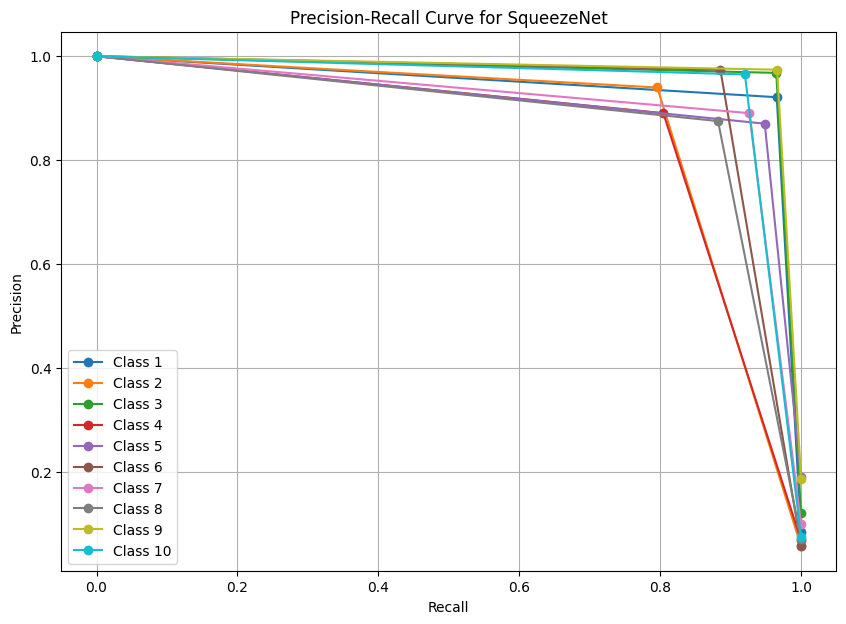

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve_multi_class(y_true, y_pred, model_name):
    precision = {}
    recall = {}
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for i in range(10):
        precision[i], recall[i], _ = precision_recall_curve((y_true == i).astype(int), (y_pred == i).astype(int))
    
    plt.figure(figsize=(10, 7))
    for i in range(10):
        plt.plot(recall[i], precision[i], marker='o', label=f'Class {i + 1}') 
    
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

# Plotting Precision-Recall curves for all models
plot_precision_recall_curve_multi_class(labels_shufflenet, preds_shufflenet, "ShuffleNet")
plot_precision_recall_curve_multi_class(labels_efficientnet, preds_efficientnet, "EfficientNet")
plot_precision_recall_curve_multi_class(labels_mobilenet, preds_mobilenet, "MobileNetV2")
plot_precision_recall_curve_multi_class(labels_squeezenet, preds_squeezenet, "SqueezeNet")